In [44]:
# Import all the libraries we'll need
import pandas as pd # For datasets
import matplotlib.pyplot as plt # For Plots
import numpy as np # For numerical operations e.g. logarithm

#Tell the application to show the plots within this webpage
%matplotlib inline

# Display only two decimals to avoid distraction
pd.set_option('display.precision', 2)

# Pretty Tables
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

def rets2prices(r):
    prices = (1+r).cumprod()
    prices.iloc[0,:] = 1
    return prices

def calc_returns(rets):
    log_rets = np.log(1 + rets)
# Simple addition
    cum_rets = rets.cumsum()
# Log Addition
    cum_logrets = np.exp(log_rets.cumsum()) - 1
# Additional types of returns
    indexed_returns = rets2prices(rets)
    money_returns = indexed_returns * 1000
    
    return log_rets, cum_rets, cum_logrets, indexed_returns, money_returns

def daily_drawdown(df):
    window = len(df)
    Roll_Max = df.rolling(window, min_periods = 1).max()
    Daily_Drawdown = 100 * (df - Roll_Max) / Roll_Max
    return Daily_Drawdown

def Backtest(rets):
    cols = ['Avg Returns', 'Avg Volatility', 'Sharpe Ratio', 'Max Drawdown']
    idx = rets.columns
    Stats = pd.DataFrame(columns = cols, index = idx)
    
    Stats['Avg Returns'] = rets.mean() * 252 * 100
    Stats['Avg Volatility'] = rets.std() * np.sqrt(252) * 100
    
    # Risk-Adjusted Average Return
    Stats['Sharpe Ratio'] = np.sqrt(252) * rets.mean() / rets.std()
    
    prices = rets2prices(rets)
    Daily_Drawdown = daily_drawdown(prices)
    Stats['Max Drawdown'] = Daily_Drawdown.min()
    
    return Stats, Daily_Drawdown    

In [31]:
InteractiveShell.ast_node_interactive = "all"
# Read data from csv files for each stock and show a data sample
data_location = './data/mkt/'

# Define sotcks for study
names = ['S&P500','Microsoft','Walmart','Amazon']
tickers = ['^GSPC','MSFT','WMT','AMZN']

# Load pricing data from the selected stacks, each from one .csv file
for i in range(len(tickers)):
    ticker_ = tickers[i].replace('^','_')
    df = pd.read_csv(data_location + ticker_ + '.csv')
    if i <= 0:      
        new_df = df[['Date','S&P500']]
        new_df.Date = pd.to_datetime(new_df.Date).copy()
        #new_df = new_df.rename(columns = {'Close':'S&P500'})
    else:          
        new_df[tickers[i]] = df[[names[i]]]

# We store only the Adjusted Close Price and we align all time series
new_df = new_df.set_index(new_df.Date)
new_df = new_df.drop('Date',axis=1)

returns = new_df.pct_change()


# Homework

Create different combinations of portfolios using these same 3 stocks.

Can you find the "optimal" porfolio?

- The optimal portfolio is the ona that results in the largest Sharpe Ratio

Note: you can vary the weights any way you want, even use negative weights.

See examples below!

Only 1 retriction:
    -All weights always add up to 1.0
    
Hint: The answer doesn't use negative weights, but you may play with them so you learn.

## Special price for the person/team (you can colaborate) who finds the largest Sharpe Ratio possible. ##

In [32]:
# We call this one 130/30 because it is 130% "long" and 30% "short"
portfolio = np.array([0.5, 0.8, -0.3])
print(np.sum(portfolio) == 1)
print(np.sum(portfolio[portfolio>0]) <= 2.0)
print(np.sum(portfolio[portfolio<0]) >= -2.0)
print()

portfolio = np.array([1.0, 1.0, -1.0])
print(np.sum(portfolio) == 1)
print(np.sum(portfolio[portfolio>0]) <= 2.0)
print(np.sum(portfolio[portfolio<0]) >= -2.0)
print()

# Another example
portfolio = np.array([0.5, 0.2, 0.3])
print(np.sum(portfolio) == 1)
print(np.sum(portfolio[portfolio>0]) <= 2.0)
print(np.sum(portfolio[portfolio<0]) >= -2.0)

True
True
True

True
True
True

True
True
True


## Analytical Solution

We want to maximize the utility ( benefit we get from investin). We like positive returns but we dislike variability, therefore:
    
$$ Maximize \space U = h^T * \alpha - \lambda * h^T * V * h $$

$$ subject \space to: \space h^T * 1 = 1 $$
    
    Then, deriving with respect to variable "h" (portfolio holdings) and equallying to zero, we can obtain the maximum:
        
$$ \frac {\delta U}{\delta h} = \alpha - 2*lambda * h ^ T * V = 0 $$

Therefore:

$$ optimal \space portfolio = h = {V ^{-1}} * \alpha $$

But since we have the restriction that the sum of all holdings should be 1.0, we divide by the sum of all h_i

$$ optimal \space portfolio = h = \frac{{V^{-1}} * \alpha}{\alpha^T * {V^{-1}} * 1} $$

Where:

$$ \alpha^T * {V^{-1}} * 1 == \sum {h_i} $$

Here we proxy alpha as Expected Return

In [33]:
# Try to make sure that T >> N
# How to extend the cov of F to cov of stocks

# Analytical Solution in code
cov_mat = returns[['MSFT', 'WMT', 'AMZN']].cov()
vec_one = np.matrix(np.ones(3))
inv_cov_mat = np.linalg.pinv(cov_mat)
exp_ret = np.matrix(returns[['MSFT', 'WMT', 'AMZN']].mean())

# Analytical solution
h = np.array(inv_cov_mat * np.transpose(exp_ret) / (exp_ret * inv_cov_mat * np.transpose(vec_one)))

print(h)

[[0.25948774]
 [0.30991918]
 [0.43059308]]


In [34]:
# Analytical solution portfolio q
hq = np.array(inv_cov_mat * np.transpose(exp_ret) / (exp_ret * inv_cov_mat * np.transpose(exp_ret)))
print(hq)

[[341.77792401]
 [408.20246599]
 [567.14512833]]


In [35]:
# Analytical solution portfolio c
hc = np.array(inv_cov_mat * np.transpose(vec_one) / (vec_one * inv_cov_mat * np.transpose(vec_one)))
print(hc)

[[0.28828692]
 [0.67657818]
 [0.03513491]]


In [36]:
sc = np.transpose(hc) @ cov_mat @ hc
sq = np.transpose(hq) @ cov_mat @ hq

In [37]:
print(sc)
print(sq)

          0
0  1.89e-04
        0
0  609.72


In [38]:
e = sq / sc
e

,0
0,3.22e+06


In [39]:
# We need the portfolio returns
returns['h'] = h[0]*returns.MSFT + h[1]*returns.WMT + h[2] * returns.AMZN

# We need to recalculate cumulative returns
log_rets, cum_rets, cum_logrets, indexed_returns, money_returns = calc_returns(returns)

print('Percentage Cumulative Return')
print(100*(cum_logrets.iloc[-1,:]))


Percentage Cumulative Return
S&P500     117.91
MSFT       472.55
WMT        183.41
AMZN      3463.88
h         1945.27
Name: 2020-07-10 00:00:00, dtype: float64


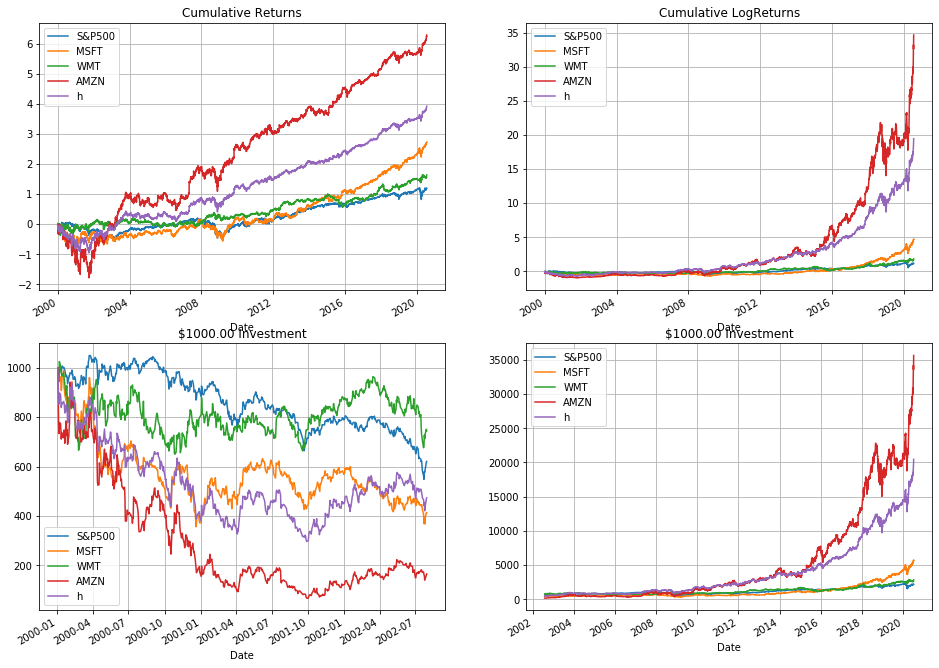

In [40]:
# Plots of returns
fig = plt.figure(figsize=(16,12))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

cum_rets.plot(ax = ax1 ,title = 'Cumulative Returns', grid = True)
cum_logrets.plot(ax = ax2 ,title = 'Cumulative LogReturns', grid = True)
# Plot money returns in 2 separeate plots so we can appreciate the first few years of the timeseries
money_returns.iloc[:len(money_returns)//8, :].plot(ax = ax3 ,title = '$1000.00 Investment', grid = True)
money_returns.iloc[len(money_returns)//8:, :].plot(ax = ax4 ,title = '$1000.00 Investment', grid = True)

In [47]:
pd.set_option('display.precision', 4)
Stats, Daily_Drawdown = Backtest(returns)
Stats

,Avg Returns,Avg Volatility,Sharpe Ratio,Max Drawdown
S&P500,5.7987,19.9611,0.2905,-56.7754
MSFT,13.3033,30.9435,0.4299,-68.7132
WMT,7.9690,24.0525,0.3313,-36.6425
AMZN,30.6804,51.9139,0.5910,-93.3203
h,19.1326,29.7603,0.6429,-70.3544


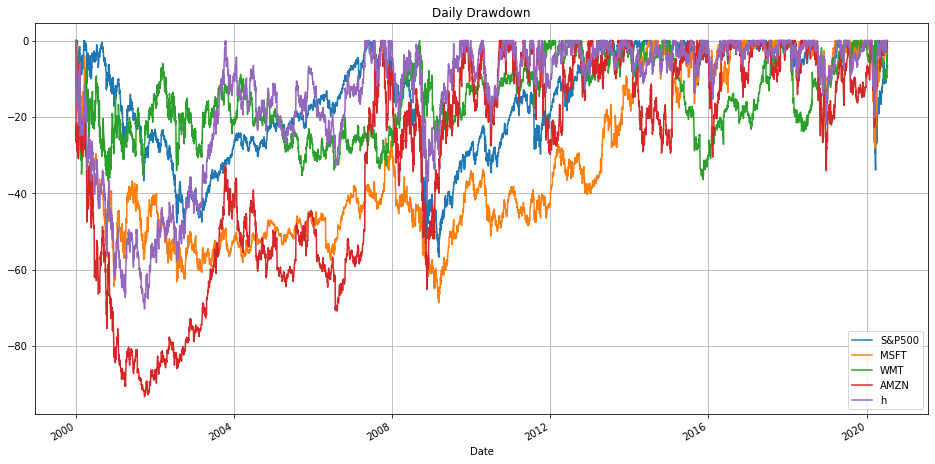

In [49]:
Daily_Drawdown.plot(title = 'Daily Drawdown', figsize = (16,8), grid = True)